In [76]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from pathlib import Path
home = str(Path.home()) # all other paths are relative to this path. change to something else if this is not the case on your system
import sys
sys.path.insert(0,'..')
from tests import benchmark_utils
from scipy import stats

SEED=42

%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Here are your tools...

### Scaling

[Standard Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html): Standardize features by removing the mean and scaling to unit variance.

[MinMax Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): Transform features by scaling each feature to a given range.





In [77]:

def scale_data(X_train=None, X_test=None, method="standard"):
    """
    Function to scale features....
    """
    techniques = {
        "standard" : StandardScaler(),
        "minmax" : MinMaxScaler(),
    }

    X_train_scaled, X_test_scaled = None, None

    scaler = techniques[method]

    if X_train is not None:
        X_train_scaled = scaler.fit_transform(X_train)
        
    if X_test is not None:
        X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

    
# Generate a simple fake dataset with 100 samples and 5 features
X, y = make_classification(n_samples=100, n_features=5, random_state=42)

# Scale the data
scale_data(X[:50], X[50:], method="standard")


(array([[-5.08298332e-01,  6.12605668e-01, -6.35089863e-01,
         -4.83750248e-01, -7.81284887e-01],
        [ 2.00611369e-01, -6.18124467e-01,  3.81110524e-01,
          5.88970660e-01,  7.27698097e-01],
        [ 1.17298745e+00,  3.98581096e-01,  8.37366565e-01,
         -8.00441957e-01, -1.15459281e+00],
        [ 1.64450877e+00, -5.60890748e-01,  1.56210936e+00,
          6.20554425e-02, -4.79967970e-01],
        [-5.33940968e-01, -1.70507689e+00,  1.46994754e-01,
          1.97586346e+00, -5.91901488e-01],
        [-1.64834032e+00,  3.71163365e-01, -1.49952807e+00,
          1.39850114e-01, -1.45589590e+00],
        [ 9.48728744e-01,  7.21784965e-01,  5.38821834e-01,
         -1.06984738e+00,  1.03973412e-01],
        [-1.26168386e+00,  1.60046954e+00, -1.60409110e+00,
         -1.28523432e+00,  1.67016322e-01],
        [ 6.64268676e-01, -6.51815702e-01,  7.78396822e-01,
          4.74842652e-01,  5.75102181e-01],
        [-1.01087041e+00, -6.09377112e-01, -6.29468376e-01,
    

## Resampling
[Synthetic Minority Oversampling Technique (SMOTE)](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/): Create new synthetic examples from the minority class that are plausible, aka are relatively close in feature space to existing examples from the minority class.

[Random Oversampling](https://imbalanced-learn.org/stable/over_sampling.html#:~:text=sampling%20samplers.-,2.1.1.%20Naive%20random%20over%2Dsampling,-%23): Generate new samples by randomly sampling with replacement the current available samples.

[Random Under Sampling](https://imbalanced-learn.org/stable/under_sampling.html): Randomly selecting a subset of data for the targeted classes.




In [78]:
def balance_dataset(X, y, method="SMOTE"):
    techniques = {
        "smote" : SMOTE(random_state=SEED),
        "random" : RandomOverSampler(random_state=SEED),
        "under" : RandomUnderSampler(random_state=SEED),
    }

    sampler = techniques[method]
    X_resampled, y_resampled = sampler.fit_resample(X, y,)

    return X_resampled, y_resampled

# Generate a simple fake dataset with 100 samples and 5 features
X, y = make_classification(n_samples=100, n_features=5, random_state=42)

# Balance the dataset
balance_dataset(X, y, method="smote")

(array([[-0.43066755,  0.67287309, -0.72427983, -0.53963044, -0.65160035],
        [ 0.21164583, -0.84389686,  0.53479393,  0.82584805,  0.68195297],
        [ 1.09267506,  0.40910605,  1.10009583, -0.94275087, -0.98150865],
        [ 1.51990078, -0.77336118,  1.99805321,  0.15513175, -0.3853136 ],
        [-0.45390127, -2.18347304,  0.24472415,  2.59123946, -0.48423407],
        [-1.46361184,  0.37531604, -1.79532002,  0.25415746, -1.24778318],
        [ 0.88948365,  0.80742726,  0.73019848, -1.28568005,  0.13074058],
        [-1.11327862,  1.89033108, -1.92487377, -1.5598485 ,  0.18645431],
        [ 0.63174629, -0.88541844,  1.02703224,  0.68057323,  0.54709738],
        [-0.88602706, -0.83311649, -0.7173148 ,  1.31217492,  0.44381943],
        [ 0.56372286, -1.47487037,  1.15509316,  1.35536951, -0.2176812 ],
        [-1.02754411, -0.32929388, -1.05383855,  0.82600732, -0.05952536],
        [ 0.19375402, -0.96314239,  0.55600276,  0.96423311, -0.20219265],
        [-0.05396947,  0.

## Vizualization


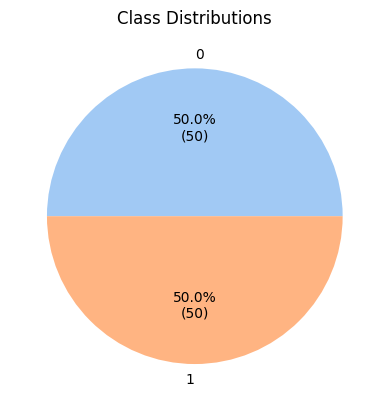

In [79]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format

def graph_distributions(y):

    class_counts = dict(Counter(y))
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    colors = sns.color_palette('pastel')[0:5]

    plt.title(label="Class Distributions")
    plt.pie(counts, labels=classes, colors = colors, autopct=autopct_format(counts))
    plt.show()

# Generate a simple fake dataset with 100 samples and 5 features
X, y = make_classification(n_samples=100, n_features=5, random_state=42)

# vizualize the class distribution
graph_distributions(y)


## Challenge 1

In [80]:
X1, y1 = benchmark_utils.challenge1()

# add dataset modifications below


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.031566,1.933520,-2.384199,0.158917,1.554706,-0.077639,0.907370,-0.796072,-2.384199,2.397373,...,-0.410263,0.739910,0.682121,-0.913715,-2.384199,0.893025,-0.935024,-1.243204,-0.077639,1.118979
1,1.447581,3.365694,-0.865155,-0.010214,1.571586,2.635575,1.781237,0.725392,-0.865155,-1.348736,...,-1.568303,-2.202812,-0.225444,-0.582711,-0.865155,-0.574319,0.104943,-1.202106,2.635575,1.402133
2,0.405312,0.482765,-1.055098,1.717437,-1.776589,-1.703094,1.467228,-0.988193,-1.055098,1.171605,...,0.092618,2.176609,0.334548,0.846814,-1.055098,0.613683,-0.586081,1.590235,-1.703094,-1.442350
3,-0.163693,1.441192,1.454684,0.978003,0.353958,3.636653,-0.052693,0.166726,1.454684,-1.108281,...,0.039246,2.274717,-0.812663,1.581080,1.454684,1.542756,-1.476725,-0.151109,3.636653,-0.062200
4,0.760240,3.068180,0.749425,-1.848904,1.675541,2.556012,-0.145091,1.924199,0.749425,0.213095,...,0.987994,2.056893,-0.211943,-1.469042,0.749425,-0.768123,0.611015,0.251525,2.556012,-1.207688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.061166,1.612341,-0.283159,-1.988509,-0.884392,0.015224,1.319714,0.935214,-0.283159,1.354838,...,0.388885,3.477714,0.636042,-0.762336,-0.283159,-1.687683,-1.256301,-1.451965,0.015224,-0.519352
996,-0.337055,-1.560308,-0.206230,-0.708676,0.765085,2.319163,-0.282725,2.781503,-0.206230,0.691920,...,-1.361390,0.049757,-1.272178,0.952296,-0.206230,-0.652209,0.449001,-0.825329,2.319163,-0.181084
997,-1.118313,-2.985954,1.193845,-1.277733,2.314603,-1.414001,-0.568766,-1.724386,1.193845,-0.710985,...,-0.641314,-1.300187,-0.087546,0.241765,1.193845,0.465426,-0.559384,2.007389,-1.414001,-0.331443
998,0.210953,0.301559,3.090557,-0.475907,0.242114,4.120683,-0.860401,2.139161,3.090557,-0.672749,...,0.980413,1.364014,-0.366166,1.162763,3.090557,1.363802,0.437552,1.732907,4.120683,-0.180054


0     -1.0
1      1.0
2      1.0
3     -1.0
4     -1.0
      ... 
995    1.0
996   -1.0
997    1.0
998   -1.0
999    1.0
Length: 1000, dtype: float64

In [ ]:
# this is only to display your dataset
X1 = pd.DataFrame(X1, columns=list(map(str, range(len(X1[0])))))
y1 = pd.Series(y1)
display(X1, y1)

## Challenge 2

In [81]:
X2, y2 = benchmark_utils.challenge2()

# add dataset modifications below


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.116374,-1.734558,1.242074,-4.824522,-1.734558,3.819788,1.898841,-5.221690,-0.519525,0.941054,2.415795,0.941054
1,-1.929926,1.425790,0.755472,-4.413806,1.425790,0.317908,-3.884590,-2.178358,-2.036416,1.175136,0.303917,1.175136
2,-2.971329,1.198771,3.180470,-2.604697,1.198771,0.672375,-5.764932,1.417821,0.420147,1.352841,-0.452868,1.352841
3,-0.759627,1.456858,0.262766,-2.735903,1.456858,-0.962846,-1.735472,-1.814438,-1.505340,0.516720,0.826810,0.516720
4,-2.238396,-0.739962,3.261074,0.993782,-0.739962,3.001251,-5.998562,3.468703,0.421443,0.814610,-4.167612,0.814610
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.811066,1.128331,0.021799,-4.427654,1.128331,1.024046,-3.673287,-2.222251,-1.899335,1.595162,0.081238,1.595162
996,-0.864894,-1.206543,-1.439789,-3.751350,-1.206543,0.591174,0.031114,-0.827583,-2.329460,1.597119,0.612150,1.597119
997,2.777545,-1.180644,1.772918,-0.425390,-1.180644,1.381189,1.189044,-0.699142,-0.503148,1.969801,-0.554285,1.969801
998,-2.837122,0.189664,1.264960,-3.758890,0.189664,4.641282,-6.029706,-0.922930,0.152463,2.240368,-1.591028,2.240368


0     -1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
995    1.0
996    1.0
997    1.0
998    1.0
999    1.0
Length: 1000, dtype: float64

In [ ]:
# this is only to display your dataset
X2 = pd.DataFrame(X2, columns=list(map(str, range(len(X2[0])))))
y2 = pd.Series(y2)
display(X2, y2)

## Challenge 3